In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
import taxis
from utils import *
from visualize import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from matplotlib import cm

DBNAME="../taxis.db"
LAT=1.380766
LON=103.891675
LAT1=1.303693
LON1=103.844952

holidays=['20170626']
def peak(h,m,w):
    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0


In [2]:
dates=taxis.get_dates(DBNAME)
dates=[str(x[0]) for x in dates]
dates


['20170624',
 '20170625',
 '20170626',
 '20170627',
 '20170628',
 '20170629',
 '20170630',
 '20170701',
 '20170702',
 '20170703',
 '20170704',
 '20170705',
 '20170706',
 '20170707',
 '20170708']

In [3]:
def process_date(date):
    if weekday(date)==0:
        return None
    df=taxis.getdf_date(DBNAME,date)
    h=df.quantile(q=0.9)['TaxiCount']
    l=df.quantile(q=0.1)['TaxiCount']
    df['Date']=date
    df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
    df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
    df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
    df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
    df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)
    df=df.query('(TaxiCount>=@l and TaxiCount<=@h) and (Hour>=6 and Hour<=12) and Weekday==1')[['X','Y','Hour','Minute','PeakHour','TaxiCount']]
    return df


In [4]:
data=[process_date(date) for date in dates]
data=[x for x in data if x is not None]

In [5]:
rf=RandomForestRegressor(n_estimators=10,criterion='mse',oob_score=True,n_jobs=5,warm_start=True)
for df in data[:-1]:
    X=df.drop(['TaxiCount'],axis=1).as_matrix()
    y=np.array(df['TaxiCount'].tolist()).reshape(-1,1)
    rf.fit(X,y)
    print rf.score(X,y)
    rf.n_estimators+=10

/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.981579199461
0.879641677819
0.882055799972
0.829599565185
0.85886613026
0.868293774587
0.896862667545
0.885853463405
0.789901277741


                  X             Y          Hour        Minute      PeakHour  \
count  61307.000000  61307.000000  61307.000000  61307.000000  61307.000000   
mean      18.315462     10.252337      8.998092     27.507462      0.285367   
std       11.302697      6.198658      1.997873     17.279430      0.451593   
min        0.000000      0.000000      6.000000      0.000000      0.000000   
25%        8.000000      5.000000      7.000000     10.000000      0.000000   
50%       18.000000     11.000000      9.000000     30.000000      0.000000   
75%       28.000000     16.000000     11.000000     45.000000      1.000000   
max       37.000000     20.000000     12.000000     55.000000      1.000000   

          TaxiCount  
count  61307.000000  
mean       1.807575  
std        3.881185  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max       18.000000  


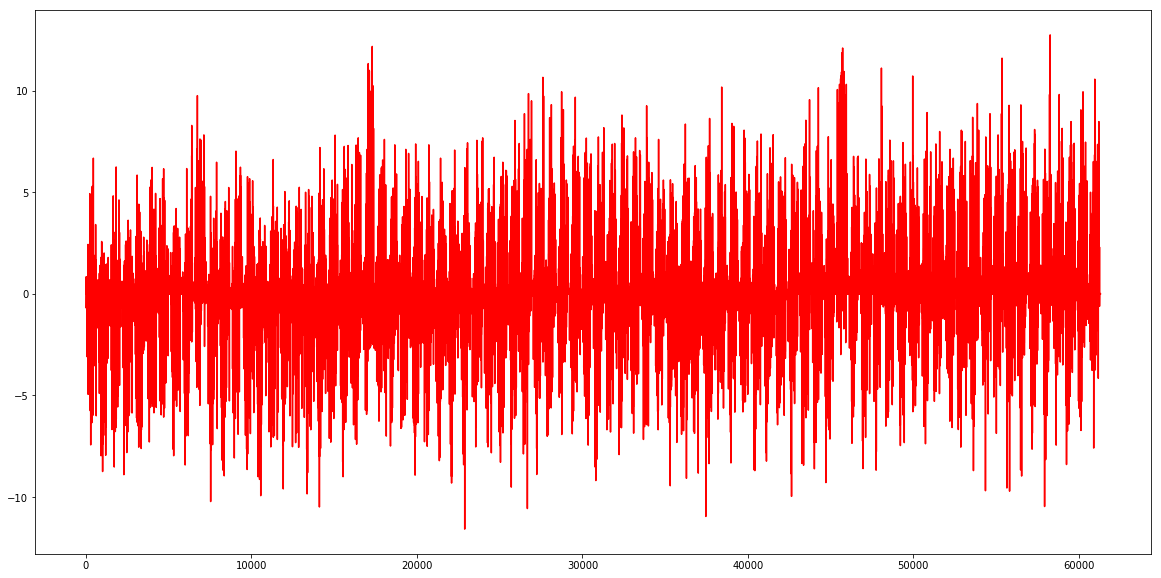

In [6]:
test=data[-1]

print test.describe()

Xt=test.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(test['TaxiCount'].tolist()).reshape(-1,1)
P=rf.predict(Xt)
e=[x-y for x,y in zip(P,yt)]


#plt.plot(yt,'-g')
#plt.plot(P,'-b')
plt.plot(e,'-r')
plt.show()